<a href="https://colab.research.google.com/github/MaggieJian/Final-AI-Coursework/blob/main/Creating_Train_and_Test_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating_Train_and_Test_Data

## IRIS
You have already learned to convert jp2 files to npy files and having created masks using Sentinel-2 images downloaded from Copernicus. For the next section, please check that you have the mask and the corresponding location information ready.

## Create the dataset from IRIS
In this section, the aim is to find the location on the original image that corresponds to the mask created and also how to create dataset for analysis from there.

First of all, you need to identify which one is your orginial image chunk (that we divide in the previous code) that corresponds to your mask. It is usually noted at thge left-bottom on you IRIS interface. Your location information should be in the format of [x1, y1, x2, y2]. We take [100, 100, 300, 400] as an example.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00


In [ ]:
# Import all packages needed
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Specify your path to files
path = '/content/drive/MyDrive/AI4EO/Mask_images/'
directory = 'mask1'
datadir = path+directory

In [ ]:
# The images are in numpy array format
image = np.load(datadir+ '/.npy')

# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [300, 500, 100, 800]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AI4EO/Mask_images/mask1/.npy'

In [ ]:
# Now also read in the mask file
mask = cv2.imread('/content/drive/MyDrive/AI4EO/Mask_images/mask1.png', cv2.IMREAD_UNCHANGED)


# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

It may be worthy to check if you find the region on the image is the one you care about (aligned with your mask).

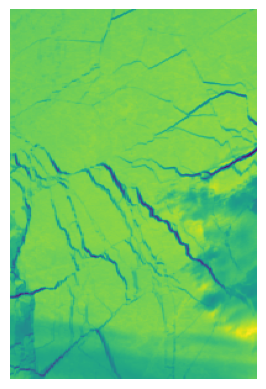

In [ ]:
# Extract channels 1, 2, and 3
channel_1 = roi[:,:,4]  # 0-based indexing for the first channel
rgb_image = np.stack([channel_1], axis=-1) # You can add more channels if you want

# Plotting the RGB image and you will see if it corresponds to the mask
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

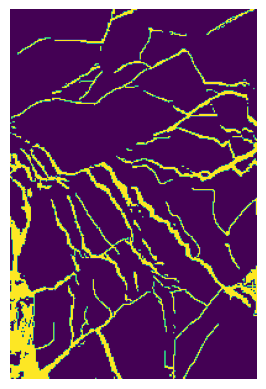

In [ ]:
# You can also plot the mask
plt.imshow(binary_mask)
plt.axis('off')
plt.show()

In [ ]:
## Another check needs to be done is their shape in first two dimensions
print(binary_mask.shape)
print(roi.shape)

(300, 200)
(300, 200, 21)


:Because we are not just using one pixel as a data instance, instead we use also the pixels around that pixel, so one instance would have shape (3,3,21).

In [ ]:
# roi is your data with shape (300, 200, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)


(59004, 3, 3, 21)


Becasue we exclude the border pixels in the previous step, we should do that also for the mask (labels) to avoid inconsisitency.

In [ ]:
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)


(59004,)


Below shows a standard way to split the data into training and testing set using 'train_test_split' form sci-kit learning package.


In [ ]:
# Assuming patches_array is your X and labels is your y
x_train, x_test, y_train, y_test = train_test_split(patches_array, labels, test_size=0.1, random_state=42)

Having secured the input data, there remains an essential step to address: managing data imbalance. Data imbalance can skew the results and compromise the accuracy of our analysis, thus it's crucial that the two classes are balanced, each having more or less an equivalent quantity. This ensures a more reliable and equitable comparison and analysis. Therefore, we abandom the training and testing sets above and create new ones.


In [ ]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 7580 # Adjust it to the amount you get

{0: 51424, 1: 7580}


In [ ]:
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))


{0: 6833, 1: 6811}


Up until here, we have our data for training and testing ready. You save them using the following code for analysis in the next section.

In [ ]:
pip install numpy

In [ ]:
import numpy as np
np.save ('X_train_balanced.npy',X_train_balanced)
np.save ('X_test_balanced.npy',X_test_balanced)
np.save ('y_train_balanced.npy',y_train_balanced)
np.save ('y_test_balanced.npy',y_test_balanced)